# Introduction to Machine Learning - Supervised Exercise 4
#### Johannes Heidecke
#### Salvador Medina

## Abstract

This document presents a possible solution to the 4th supervised learing exercise for the Introduction to Machine Learning subject. It presents a simple implementation of the AdaBoost ensemble classificator as well as a weak learner based on decision stumps to be used with it. Basic evaluation of the implementd AdaBoost classifier is also provided.
The document also presents an analysis and possible solution to the churn detection problem presented in the exercise's definition. The expected profit that could be obtained by making retention campaigns to expected churn clients is also studied.

## Introduction

Analsysis of data is something of great importance for companies nowadays. Companies want to learn from their clients behaviour in order to better understand their needs. This is a very complicated task, as there can be multiple and inter-related variables so complex machine learning mechanisms are usually needed.

One such case is churn detection, that is, tring to detect if a client is going to leave a certain service subscription or not. This is in fact the problem that the 4th practice of supervised machine learning presents to us. 

## Specification of the problem

For this practice, we want to create a classifier that detects customers who want to quit their subscription with a tele-communications company. Since retaining existing customers is often cheaper than attaining new ones, it can be very valuable to classify customers who are likely to quit and try to keep them with the company based on some campaign.

Based on data provided in *churn.csv*, we train a model that distinguishes between customers that are going to quit (positive class) and customers that will stay (negative class). The company can then start a targeted campaign for all customers of the positive class with an expected profit increase of:

$$ P_{inc} = TP \cdot (\beta \cdot p - c) + FP \cdot (-c) $$

with $TP$ being the true positives, $\beta$ being the success chance of the campaign, $p$ being the profit per subscribed customer, $c$ being the cost of the campaign per customer and $FP$ being the false positives (customers that were falsely classified as likely to quit).

If $ \beta \cdot p > c $ is given, the company wants to maximize the true positives while minimizing the false alarms. Since there is a trade-off between the true-positive-rate (TPR) and false-positive-rate (FPR), we have to find an optimal point on the receiver-operating-characteristic (ROC) curve that maximizes the expected profit. It is, however, possible, that even the best $ P_{inc} $ of the campaign is small due to a bad ratio of $TP$ and $FP$, in these cases it should be considered investing the money in a campaign of acquiring new customers.

The provided data to train the model consists of several attributes such as *account_length*, *total_international_calls*, and *number_calls_customer_service*. The data first has to be pre-processed and normalized (see Work Package 1). We implement the classifier as part of the sklearn framework (see Work Package 2 & 3) and test the results (Work Package 4) while comparing it to existing sklearn implementations (Work Package 5). Finally, we focus on the campaigns expected profit and how to maximize it by finding the best ratio between TPR and FPR (Work Package 6).

## Source Code 
##### Work Package 3
The following code blocks contain our own implementation of the AdaBoost classifier. A simple implementation of a weak learner based in decision stumps, equivalent to a decision tree of depth 1 is also provided.

In [1]:
"""
This block contains all imports needed for defining new estimators
in sklearn.
"""

# Auxiliar imports
import numpy as np
import math

# Base classes of estimators in sklearn
from sklearn.base import BaseEstimator, ClassifierMixin

# AdaBoost Classifier provided by sklearn
from sklearn.ensemble import AdaBoostClassifier

# Base class of all ensemble estimators in sklearn
from sklearn.ensemble import BaseEnsemble

# sklearn's implementation of weak learner that we will be using
from sklearn.tree import DecisionTreeClassifier

# Auxiliar functions for validations
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [2]:
"""
Define the weak learner class - A simple decision stump
This class should be equivalent to sklearn.tree.DecisionTreeClassifier with
max_depth=1. This classifier is slower than the one provided by skelearn so
as soon as we prove that the results are equivalent, we will be able to
use the default one.
"""

class WeakLearner(BaseEstimator, ClassifierMixin):

    def __init__(self, num_steps=10):
        self.num_steps=num_steps
        self.dimension_=None
        self.threshold_=None
        self.possitive_class_=None
        self.negative_class_=None
    
    def _predict(self, X, dimension, threshold, positive_class, negative_class):
        result = np.ones(len(X))*positive_class
        for i in range(len(X)):
            if X[i, dimension] <= threshold:
                result[i] = negative_class
        return result
    
    def _fit(self, X,y, sample_weight, dimension, threshold):
        min_error=np.inf
        p_class=None
        n_class=None
        for p in self.classes_:
            for n in self.classes_:
                if p != n:
                    predicted=self._predict(X, dimension, threshold, p, n)
                    error = np.ones(len(X))
                    error[predicted == y] = 0
                    weighted_error = np.dot(sample_weight,error)
                    if weighted_error < min_error:
                        p_class=p
                        n_class=n
                        min_error=weighted_error
        return min_error, p_class, n_class
    
    def predict(self, X):
        # Check if the classifier has been fitted
        check_is_fitted(self, ['dimension_','threshold_','positive_class_', 'negative_class_'])
        # Check the input array
        X = check_array(X)
        return self._predict(X, self.dimension_, self.threshold_, 
                             self.positive_class_, self.negative_class_)
    
    def fit(self, X, y, sample_weight=None):
        # Get the classes
        self.classes_ = np.unique(y)
        
        # Check the input array
        X,y = check_X_y(X,y)
        
        n_examples,n_features = np.shape(X)
        if sample_weight is None:
            sample_weight = np.ones(n_examples)*(1/n_examples)
        min_error = np.inf     
        for dimension in range(n_features):
            min_range = X[:,dimension].min()
            max_range = X[:,dimension].max()
            step_size = (max_range - min_range)/self.num_steps
            for increments in range(self.num_steps):
                threshold=min_range+increments*step_size
                error, p_class, n_class = self._fit(X, y, 
                                                    sample_weight, dimension,threshold)
                if error < min_error:
                    min_error = error
                    self.positive_class_=p_class
                    self.negative_class_=n_class
                    self.dimension_ = dimension
                    self.threshold_ = threshold
                    

In [3]:
"""
Define our implementation of the AdaBoost Classifier
This ensemble estimator is multiclass (even though it was not in the slides)
so that it could be easily compared with the one provided in sklearn and
the datasets included in it could also be executed (they are all multiclass)
"""

class DiscreteAdaBoostClassifier(BaseEnsemble, ClassifierMixin):

    # The default number of estimators is the same as in sklearn's
    # implementation.
    def __init__(self, base_estimator=None,
                 n_estimators=50, estimator_params=tuple()):
        
        self.estimator_weights_ = []
        self.estimator_errors_ = []
        self.estimators_ = []
        
        super(DiscreteAdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            estimator_params=estimator_params)
        
    def fit(self, X, y, sample_weight=None):
        
        # Checks input
        X, y = check_X_y(X,y)
        
        # We allow it to be multiclass
        # The only differences in the implementation is that all multimplications
        # that imply that classes are -1 and 1 are now equalilty comparisons
        self.classes_ = np.unique(y)
        
        # Validates the estimator
        self._validate_estimator(default=DecisionTreeClassifier(max_depth=1))
        
        total_weights = len(X)
        
        if sample_weight is None:
            # Set an initial value to the weights to 1/n
            sample_weight = np.ones(total_weights)*(1.0 / total_weights)
        
        for i in range(0, self.n_estimators):
            
            # Create the weak classifier
            classifier = self._make_estimator(append=False)
            classifier.fit(X, y, sample_weight=sample_weight)
            
            # Classify the whole training set
            predictions = classifier.predict(X)
            
            # Calculate the weighted error
            error = 0.0
            
            for si in range (total_weights):
                if y[si] != predictions[si]:
                    error+=sample_weight[si]
            
            # Error should never be 1.0 BUT it can be 0.0, in that case
            # the logarithm is not defined. We should halt execution and use 
            # just one classifier.
            
            self.estimators_.append(classifier)
            self.estimator_errors_.append(error)
            
            if error == 0.0:
                # It can be calculated with just one weak classifier
                self.estimator_weights_.append(1.0)
                break
            else:
                # Calculate the weight of the estimator (alpha)
                alpha = 0.5 * math.log((1.0 - error)/error, math.e)
                self.estimator_weights_.append(alpha)
                sample_weight = self._update_weights(alpha, y, predictions, sample_weight)

    
    def _update_weights(self, alpha, y, predictions, weights):
        for i in range(0, len(weights)):
            if y[i] == predictions[i]:
                exponent=-alpha
            else:
                exponent=alpha
            weights[i] = (weights[i] * math.pow(math.e, exponent))
            
        # Normalise the weights
        sum_weights = sum(weights)
        return weights/sum_weights        
    
    def predict(self, X):
        # Check if it has been fitted
        check_is_fitted(self, ['estimators_','estimator_weights_'])
        
        # Check the input array
        X = check_array(X)
        
        # Create an len(X) * n_classes array with the weights for each class
        classes = self.classes_[:, np.newaxis]
        pred = sum((estimator.predict(X) == classes).T * w
                       for estimator, w in zip(self.estimators_,
                                               self.estimator_weights_))
        # For each element, select the class with highest weight
        result = []
        for i in range(len(X)):
            result.append(self.classes_[np.argmax(pred[i])])
        return result
    
    def _predict_binary(self, X):
        """
        This implementation follows the algorithm proposed in the slides 
        but is not multiclass
        """
        # Check the input array
        X = check_array(X)
        
        # Initial values for the ponderated weight
        result = np.zeros(len(X))
        
        for i in range(0, len(self.estimators_)):
            clf_result = self.estimators_[i].predict(X)
            # Multiply the result by its weight
            result = result+(clf_result*self.estimator_weights_[i])
        return result

## Experiments
In this section, we list all the experiments that we have performed. The response to the suggested work packages can be found in the different codes blocks of code.

### Analysis and preprocessing of the data
##### Work Packages 1 and 2
First, we will read and process the input data. The different changes that have to be made to the raw data in the provided 'churn.csv' file are the following:
- Discard unuseful or redundant information. In particular, the Phone column should be discarded.
- Convert binary values to 1.0 for the positive values and -1.0 for the negative ones. This has to be done to the columns Int'l Plan, VMail Plan and Churn?. 
- Convert numeric values to floating point and normalise them.
- Unzip categorical features into as many sub-features as different categorical labels. This is needed for the columns State and Area Code
- Extract the column Churn? to a vector of labels 'y' and the rest of the columns to a matrix 'X'.

In [4]:
"""
Work Package 1
"""

import pandas as pd
from sklearn.utils import as_float_array
from sklearn.preprocessing import maxabs_scale, minmax_scale

input_data = pd.read_csv('churn.csv')

# Drop unuseful information
input_data.drop('Phone',axis=1, inplace=True)

# Binary data to numerical, it is equivalent to extract 
# as categorical and remove one of the added columns
input_data = pd.get_dummies(input_data, 
                            columns=["Int'l Plan", 'VMail Plan', 'Churn?'], 
                            drop_first=True)

# Unzip categorical features
input_data = pd.get_dummies(input_data, columns=['State', 'Area Code'])

# Get the array of labels
y = minmax_scale(as_float_array(
        input_data['Churn?_True.'].as_matrix()), 
                 feature_range=(-1.0, 1.0))

# Get the matrix of features
X = minmax_scale(as_float_array(
        input_data.drop('Churn?_True.', axis=1).as_matrix()), 
                 feature_range=(-1.0,1.0))

In [5]:
"""
Work Package 2
"""

# Check if the problem is balanced or not
total_positive = int(sum(y[y==1.0]))
total_negative = -int(sum(y[y==-1.0]))
mcd = math.gcd(total_negative, total_positive);
print('Positive class =>', total_positive)
print('Negative class =>', total_negative)
print('Relation =>',int(total_positive/mcd),":", int(total_negative/mcd))
# The relation is 161 to 950, the problem is clearly unbalanced

accuracy_base_line = total_negative/(total_negative+total_positive)
# Having that this is an unbalanced problem, the baseline for the accuracy is
print('Accuracy Baseline =>', accuracy_base_line)

# Check if the points are linearly separable
# We use a simple linear gradient descend classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
linear_classifier = SGDClassifier()
# Get the accuracy score
linear_classifier.fit(X, y)
score_sgd= linear_classifier.score(X,y)
print('Accuracy for SGDClassifier in Training Corpus =>', score_sgd)
# We don't have perfect accuracy, the model does not seem to be linearly separable

Positive class => 483
Negative class => 2850
Relation => 161 : 950
Accuracy Baseline => 0.8550855085508551
Accuracy for SGDClassifier in Training Corpus => 0.864386438644


### Testing the classifier
##### Work Package 4
In this section, the reader can find some tests performed on the implemented classifiers as well as a simple comparison with the classifiers provided by the sklearn library. 

In [6]:
"""
Work Package 4:
Test your Classifier
"""

# We first check the accuracy of the weak learner that we will be using
decision_stump = WeakLearner()
scores_wl = cross_val_score(decision_stump, X, y, cv=10, n_jobs=-1)
print('Accuracy for WeakLearner =>', scores_wl.mean(), '( std =', scores_wl.std(),')')
# We should expect to have similar accuracy to what we got for the SGDClassifier

Accuracy for WeakLearner => 0.86559044074 ( std = 0.0071224087769 )


In [7]:
# If we compare the result with the DecisionTreeClassifier with depth 1 provided
# by sklearn, we should get similar results, as the algorithm similar
decision_tree_1 = DecisionTreeClassifier(max_depth=1)
scores_dt1 = cross_val_score(decision_tree_1, X, y, cv=10, n_jobs=-1)
print('Accuracy for DecisionTree (Depth=1) =>', scores_dt1.mean(), '( std =', scores_dt1.std(),')')

Accuracy for DecisionTree (Depth=1) => 0.866794339249 ( std = 0.00900021576451 )


In [8]:
# We then execute our AdaBoost classifier
adaboost = DiscreteAdaBoostClassifier(base_estimator=WeakLearner())
scores_ab = cross_val_score(adaboost, X, y, cv=10, n_jobs=-1)
print('Accuracy for AdaBoost with WeakLearner =>', scores_ab.mean(), '( std =', scores_ab.std(),')')

Accuracy for AdaBoost with WeakLearner => 0.869490748233 ( std = 0.0106290065326 )


In [9]:
# If we use decision trees of depth 1 as implemented by sklearn,
# we should get the same performance, as the algorithm is almost the same;
# but in less time, as the implementation is more efficient.

adaboost_dt1 = DiscreteAdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))
scores_ab_dt1 = cross_val_score(adaboost_dt1, X, y, cv=10, n_jobs=-1)
print('Accuracy for AdaBoost with DecisionTrees =>', scores_ab_dt1.mean(), '( std =', scores_ab_dt1.std(),')')

# Considering this result, we will use the class DecisionTreeClassifier provided
# by sklearn instead of our own implementation

Accuracy for AdaBoost with DecisionTrees => 0.876689863516 ( std = 0.0111654465056 )


In [10]:
# Another option is to use random threshold in the decision trees.
adaboost_rdt1 = DiscreteAdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1, splitter='random'))
scores_ab_rdt1 = cross_val_score(adaboost_dt1, X, y, cv=10, n_jobs=-1)
print('Accuracy for AdaBoost with Random DecisionTrees =>', 
      scores_ab_rdt1.mean(), '( std =', scores_ab_rdt1.std(),')')
# We also see that there is no difference compared to the non-random case


Accuracy for AdaBoost with Random DecisionTrees => 0.876689863516 ( std = 0.0111654465056 )


In [11]:
# If we use the AdaBoost implementation in sklearn
sklearn_adaboost_dt1 = AdaBoostClassifier(
    algorithm='SAMME',
    base_estimator=DecisionTreeClassifier(max_depth=1))
scores_skab_dt1 = cross_val_score(sklearn_adaboost_dt1, X, y, cv=10, n_jobs=-1)
print('Accuracy for Sklearn\'s AdaBoost =>', scores_skab_dt1.mean(), '( std =', scores_skab_dt1.std(),')')



Accuracy for Sklearn's AdaBoost => 0.876689863516 ( std = 0.0111654465056 )


Surprisingly, we cannot improve the accuracy obtained by the simple decision stump classifier by much using the AdaBoost classifier. We might need to use a different weak learner or a different non-linear classifier. In the next section we explore other weak learners in order to see if we can get better results.

### Evaluating the classifier
##### Work Package 5
In this section, the implemented classifier is compared to other classifiers already implemented in sklearn. For each tested classifier, we will check accuracy and weighted f1 score as well as the standard deviation of both metrics.

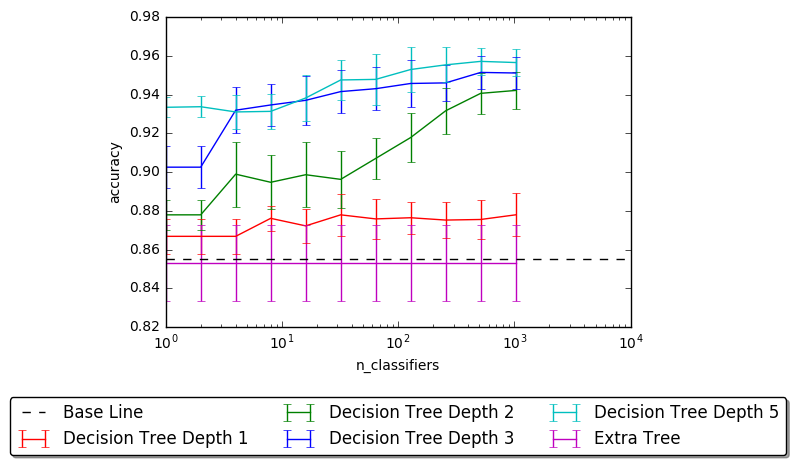

In [12]:
from sklearn.tree import ExtraTreeClassifier

# We start by testing our classifier with different number of classifiers
n_estimators_range = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
classifier_options = [
    ('r', 'Decision Tree Depth 1', DecisionTreeClassifier(max_depth=1)),
    ('g', 'Decision Tree Depth 2', DecisionTreeClassifier(max_depth=2)),
    ('b', 'Decision Tree Depth 3', DecisionTreeClassifier(max_depth=3)),
    ('c', 'Decision Tree Depth 5', DecisionTreeClassifier(max_depth=5)),
    ('m', 'Extra Tree', ExtraTreeClassifier())
]

import matplotlib.pyplot as plt
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xscale('log')
ax.set_xlabel('n_classifiers')
ax.set_ylabel('accuracy')

ax.axhline(accuracy_base_line, color='k', linestyle='--', label='Base Line')

for color, label, estimator in classifier_options:
    mean_serie = []
    std_serie = []
    for n_estimators in n_estimators_range:
        classifier = DiscreteAdaBoostClassifier(n_estimators=n_estimators,
                                               base_estimator=estimator)
        accuracy = cross_val_score(classifier, X, y, cv=10, n_jobs=-1, scoring='accuracy')
        mean_serie.append(accuracy.mean())
        std_serie.append(accuracy.std())
    ax.errorbar(n_estimators_range, mean_serie, std_serie, color=color, label=label) 
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=3)
plt.show()

The previous graph shows the accuracy obtained by the AdaBoost classifier when using different types weak learners respect to the number of estimators used. 
We can see that the performance obtained when using a simple decision stump does not increase much with the number of estimators. If we use a deeper decision tree though, we can see a clear increase in the performance.
One limitation of simple decision stumps is the fact that they only consider one feature of the data each time. This means that the different features are mutually independent. This might be the reason behind the low performance obtained by the AdaBoost classifier when using decision trees of depth 1 (decision stumps).
Overfitting does not seem to be a problem in any of the cases, as the accuracy keeps increasing when increasing the number of weak learners.
The Extra Tree (Random Decision Tree) does not seem to peform well (below the baseline) for this problem, at least when using the default parameters. Having into account that the number of features that we are considering is so big and many of them might be irrelevant, making random guesses does not seem to be a good idea. 

In [13]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
classifiers = [
    ('Decision Stump',
        DecisionTreeClassifier(max_depth=1)),
    ('Decision Tree (Depth 2)',
        DecisionTreeClassifier(max_depth=2)),
    ('Decision Tree (Depth 3)',
        DecisionTreeClassifier(max_depth=3)),
    ('Decision Tree (Depth 5)',
        DecisionTreeClassifier(max_depth=5)),
    ('Decision Tree (Depth 10)',
        DecisionTreeClassifier(max_depth=10)),
    ('AdaBoost (256 DS)',
        DiscreteAdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                                  n_estimators=256)),
    ('AdaBoost (256 DT2)',
        DiscreteAdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                  n_estimators=256)),
    ('AdaBoost (256 DT3)',
        DiscreteAdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                  n_estimators=256)),
    ('AdaBoost (256 DT5)',
        DiscreteAdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                                  n_estimators=256)),
    ('Random Forest (8 Est)',
        RandomForestClassifier(n_estimators=8)),
    ('Random Forest (32 Est)',
        RandomForestClassifier(n_estimators=32)),
    ('Random Forest (256 Est)',
        RandomForestClassifier(n_estimators=256)),
    ('SVM (Linear)',
        LinearSVC()),
    ('SVM (Degree 3)',
        SVC(kernel='poly')),
    ('SVM (RBF)',
        SVC(kernel='rbf'))
]

results = []
for classifier in classifiers:
    accuracy = cross_val_score(classifier[1], X, y, cv=10, n_jobs=-1, scoring='accuracy')
    f1_weighted = cross_val_score(classifier[1], X, y, cv=10, n_jobs=-1, scoring='f1_weighted')
    results.append((classifier[0], accuracy.mean(), 
                         accuracy.std(), f1_weighted.mean(), f1_weighted.std()))

/Users/Ihcrul/anaconda/envs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ihcrul/anaconda/envs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ihcrul/anaconda/envs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ihcrul/anaconda/envs/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 

In [14]:
# Present the table

import pandas as pd

frame = pd.DataFrame(results)
frame.columns=['classifier', 'mean_accuracy', 'std_accuracy', 'mean_wf1', 'std_wf1']

print(frame)

                  classifier  mean_accuracy  std_accuracy  mean_wf1   std_wf1
0             Decision Stump       0.866794      0.009000  0.843700  0.011130
1    Decision Tree (Depth 2)       0.877890      0.007911  0.869059  0.008749
2    Decision Tree (Depth 3)       0.902492      0.010745  0.885200  0.014950
3    Decision Tree (Depth 5)       0.933394      0.005150  0.930300  0.006075
4   Decision Tree (Depth 10)       0.937900      0.007303  0.935567  0.008094
5          AdaBoost (256 DS)       0.875192      0.009354  0.858235  0.012013
6         AdaBoost (256 DT2)       0.931589      0.011936  0.927516  0.013690
7         AdaBoost (256 DT3)       0.945993      0.009119  0.943421  0.010423
8         AdaBoost (256 DT5)       0.955302      0.009014  0.952994  0.009700
9      Random Forest (8 Est)       0.925891      0.009886  0.917663  0.011430
10    Random Forest (32 Est)       0.942401      0.009898  0.937265  0.011346
11   Random Forest (256 Est)       0.942700      0.014211  0.937

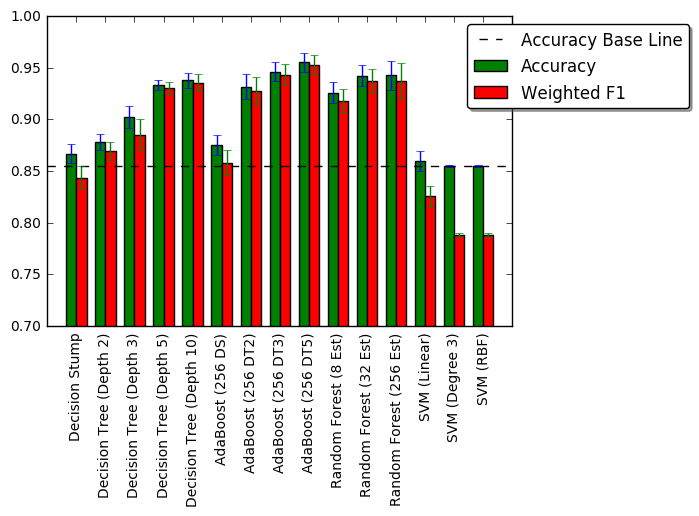

In [15]:
# Plot the table
plt.close()
fig, ax = plt.subplots()

ind = np.arange(len(frame.index.tolist()))+0.675  # the x locations for the groups
width = 0.35       # the width of the bars
ax.axhline(accuracy_base_line, color='k', linestyle='--', label='Accuracy Base Line')
ax.bar(ind, 
        frame['mean_accuracy'], 
        width,
        color='g', 
        yerr=frame['std_accuracy'], 
        label='Accuracy')
ax.bar(ind + width, 
        frame['mean_wf1'], 
        width,
        color='r', 
        yerr=frame['std_wf1'], 
        label='Weighted F1')

ax.set_ylim([0.7,1.0])
ax.set_xticks(ind + width)
ax.set_xticklabels(frame['classifier'], rotation='vertical')
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0),
          fancybox=True, shadow=True, ncol=1)
plt.show()

The best accuracy and weighted f1 score are obtained for the AdaBoost classifier with 256 estimators based on Decision Trees of depth 5. The differences though are so small (about 0.008 in both accuracy and weighted f1) that we could want to select Decision Trees with smaller depth as the base estimator in order to speed up the process. 

We can also see that random forests perform better than AdaBoost with decision stumps, even for a small number of estimators. Decision trees with big depth also give better results than AdaBoost with decision stumps and offer a performance that is comparable to random forests. We also see that there is not a big difference in performance between decision trees of depth 5 and 10, just about 0.002 in both accuracy and weighted f1.

We have obtained the worst performance levels with SVM classifiers (Using the default sklearn parameters). This does not neccesarily means that SVMs are worse suited for this classification task, as we did not have time to successfully optimize their parameters. A more exhaustive study should be carried out but this is outside the scope of this exercise.

### Analysis of the retention campaign
##### Work Package 6
In this section, we study a practical case where we can apply the classifier that we have built. The idea is to improve the company's benefit by trying to retain those clients that are predicted as possible churn. 
We consider that the benefit that we obtain from any given client is 100 euros. We have to find the best classifiers for different retention costs. The benefit will then be 100 euros for those clients correctly classified as not churn, 0 euros for clients incorrectly classified as not churn and 100 euros minus the retention cost for the rest.

In [16]:
# We first define the new score
from sklearn.metrics import make_scorer
def score_benefit(y, predicted, benefit, retention):
    benefit_with_retention = benefit - retention
    predicted_matrix = np.matrix(predicted)
    total=np.bitwise_and(y==-1, predicted_matrix==-1).sum()*benefit
    total+=(predicted_matrix==1).sum()*benefit_with_retention
    base = (y==-1).sum()*benefit
    return total/float(base)

In [17]:
# First we study the benefit obtained with our classifier with no modification
# The baseline that we will be considering is the case where we do nothing for retention
# In order to speed up calculations we will be using 16 DecisionTreeClassifiers estimators
# with a maximum depth of 3. Better results might be obtained with a higher number of
# classifiers and bigger depth.

classifier = DiscreteAdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=16)

classifier_balanced = DiscreteAdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3, class_weight='balanced'),
    n_estimators=16)

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='constant', constant=-1.0)

mean = [[],[],[]]
std = [[],[],[]]

for cost in range(0, 110, 10):
    benefit = cross_val_score(
        dummy, X, y, cv=10, n_jobs=-1, 
        scoring=make_scorer(score_benefit, greater_is_better=True, benefit=100.0,retention=cost))
    mean[2].append(benefit.mean())
    std[2].append(benefit.std())
    
    benefit = cross_val_score(
        classifier, X, y, cv=10, n_jobs=-1, 
        scoring=make_scorer(score_benefit, greater_is_better=True, benefit=100.0,retention=cost))
    mean[0].append(benefit.mean())
    std[0].append(benefit.std())
    
    benefit = cross_val_score(
        classifier_balanced, X, y, cv=10, n_jobs=-1, 
        scoring=make_scorer(score_benefit, greater_is_better=True, benefit=100.0,retention=cost))
    mean[1].append(benefit.mean())
    std[1].append(benefit.std())

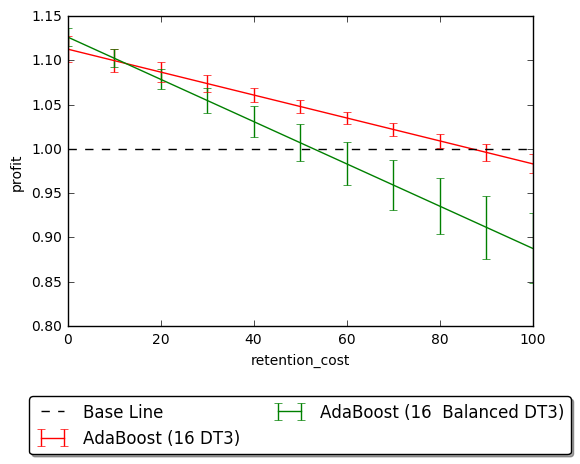

In [18]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('retention_cost')
ax.set_ylabel('profit')
ax.errorbar(range(0,110,10), mean[0], std[0], color='r', label='AdaBoost (16 DT3)')
ax.errorbar(range(0,110,10), mean[1], std[1], color='g', label='AdaBoost (16  Balanced DT3)') 
ax.plot(range(0,110,10), mean[2], color='k', linestyle='--', label='Base Line')     
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
plt.show()

As it can be seen in the graph, higher benefit could be obtained by making retention campaigns to clients detected as potential churn by our unbalanced AdaBoost classifier if the cost of the campaign is equal or less than 80 euros. The balanced classifier gets worse results and is not recommendable.

### Adding class information to the classifier
Two possible ways to improve the performance of the algorithm are to change the initial value of the sample weights or to modify the class weights and see if the performance improves or is reduced.
In the following blocks of code, we evaluate the aforementioned modifications.

In [19]:
# The first thing that we will do is to make the class weights 
mean_by_profit = []
std_by_profit = []
for cost in range(0, 110, 10):
    benefit = cross_val_score(
        DiscreteAdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=3, class_weight={1.0:(100.0-cost)/100.0,-1.0:1}),
            n_estimators=16), X, y, cv=10, n_jobs=-1, 
        scoring=make_scorer(score_benefit, greater_is_better=True, benefit=100.0,retention=cost))
    mean_by_profit.append(benefit.mean())
    std_by_profit.append(benefit.std())

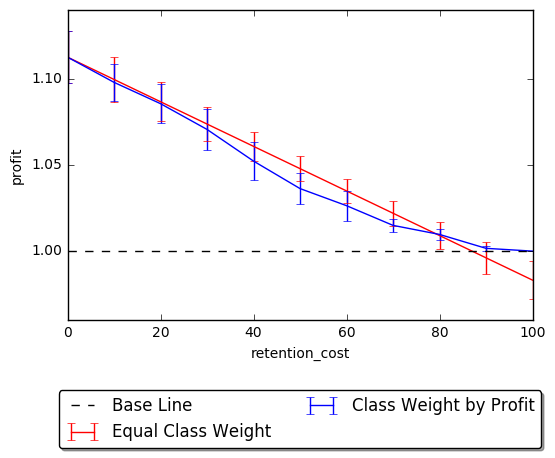

In [20]:
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('retention_cost')
ax.set_ylabel('profit')
ax.errorbar(range(0,110,10), mean[0], std[0], color='r', label='Equal Class Weight')
ax.errorbar(range(0,110,10), mean_by_profit, std_by_profit, color='b', label='Class Weight by Profit') 
ax.plot(range(0,110,10), mean[2], color='k', linestyle='--', label='Base Line')     
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)
plt.show()

We can see that by changing the class weights we can build a classifier that is aware of the potential profit of each class and is more conservative as a result. The final profit is usually below the classifier with equal class weights but in this case it never goes below the base line.



## Conclusions and Future Work

The presented problem of churn detection can be solved by using machine learning algorithms with relatively high levels of accuracy. Also, it is possible to increase the company's benefit by making retention campaigns to the clients detected as potential churn by the aforementioned classifier.

### Conclusions on churn detection

AdaBoost classifiers can be a good option for carrying out this task, but this is subject to the weak learner used. Decision stumps as weak learners do not seem to be a good option, as they cannot model the relations between different features of the data. When using decision trees of bigger depth, the accuracy of the AdaBoost classifier increases. AdaBoost classifiers with more complex weak learners give good results with a smaller number estimators, so there exists a trade-off between the number of estimators and the complexity of those.

Random forest classifiers also seem to be suitable for this problem, as they give similar results to AdaBoost classifiers with a high number of complex weak learners even with a small number of estimators. For instance, the performance levels obtained with a random forest classifier of 32 estimators is comparable to a AdaBoost classifier with 256 decision tree estimators of depth 2.

In the experiments that we have carried out, Support Vector Machines have been performing worse than both AdaBoost and random forests. In fact, the accuracy obtained was more than 10% below the accuracy base line. This does not necessarily mean that SVMs are worse suited for this classification task, as the number of experiments that we have carried out is too limited. More experimentation is required to assert whether or not the performance of SVMs is worse for this particular data set.

### Conclusions on client retention

With our experiments, we have proved that for retention campaigns costing form 0 to 80€, we can increase the benefit of the company with our classifier. For example, if the retention cost is 50€ (half of the estimated profit for a given client), we can increase the company's profit by 6% in average.

Using class weights that are proportional to the expected profit for both clients that have to be retained and clients that do not gives slightly worse performance than the case where both classes have the same weight but makes sures that the profit never goes below the base line, no matter the cost of the retention campaign.

### Future work

Due to time constraints, the experiments carried out in this document are limited and the classifier parameters are not well optimised. Also, we did not have time to expore all classifiers provided by sklearn nor we could try other weak learners for our AdaBoost implementation.

Some of the points where the work presented in this document could be extended are the following:

- Optimise the parameters of the different classifiers used. This is specially important in the case of the SVMs classifiers.

- Evaluate other types of classifiers, like Bagging, Naive Bayes and neural networks.

- Explore other strategies to improve the retention campaigns. This includes using other weights for the classes and examples and trying other classifiers.



## Bibliography

- Scikit-learn's API (http://scikit-learn.org/stable/modules/classes.html)
- Induction of One-Level Decision Trees. Iba, Wayne; and Langley, Pat (1992).
- A Short Introduction to Boosting. Yoav Freund Robert E. Schapire (1999).
- Random Decision Forests. Ho, Tin Kam (1995).                                           
